### Individual solution with the plots

In [1]:
using PyCall
using Distributions
using Statistics

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot


## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"
plotdir = "/home/stephane/Science/cluster/GAIA/products/test"

cd(wdir)

## bais properties of a cluster

┌ Info: Recompiling stale cache file /home/stephane/.julia/compiled/v1.0/GaiaClustering.ji for GaiaClustering [top-level]
└ @ Base loading.jl:1184


In [2]:
function getdata(filevot)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [4.0,5.0,1.0]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 
    return(df, dfcart , dfcartnorm)
end

getdata (generic function with 1 method)

In [3]:
## label from the dbscan labels with maximum stars
function _find_cluster_label(labels)
    let
    i = 1 ; nmax = 0 ; ilabel = 1
        for ilab in labels
            nlab = length(ilab)
            if nlab > nmax
                ilabel = i
                nmax= nlab
            end
            i += 1
        end
    return(ilabel, nmax)
    end
end

## compute the properties of the cluster with indices indx
function _get_properties_SC(indx, df::GaiaClustering.Df, dfcart::GaiaClustering.Df)::GaiaClustering.SCproperties
    nstars   = length(indx)
    distance = mean(df.data[3,indx])
    l        = mean(df.data[1,indx])
    b        = mean(df.data[2,indx])
    vra      = mean(df.data[4,indx])
    vdec     = mean(df.data[5,indx])
    xdisp    = std(dfcart.data[1,indx])
    ydisp    = std(dfcart.data[2,indx])
    zdisp    = std(dfcart.data[3,indx])
    vradisp  = std(df.data[4,indx])
    vdecdisp = std(df.data[5,indx])
    
    sc = GaiaClustering.SCproperties(nstars , distance, l , b , vra , vdec ,  xdisp , ydisp , zdisp , vradisp, vdecdisp)
    return(sc)
    
end


function _plot_cluster(plotdir, voname, indx, sc::GaiaClustering.SCproperties, df::GaiaClustering.Df, showplot = true , cmap = "gist_stern")

    PyPlot.plt[:figure](figsize=(9.0,13.0))

    PyPlot.plt[:subplot](3, 2, 1 , xlim = [-20,20] , ylim = [-20,20])
    xx = df.data[2,indx]
    yy = df.data[3,indx]
    ## A circle of radius std(z)
    # xc = mean(df.data[2,indx]) ; yc = mean(df.data[3,indx])
    # circle1 = PyPlot.plt[:Circle](0.,0.,1.)
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Y (pc)")
    PyPlot.plt[:ylabel]("Z (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 2, 2 , ylim = [-20,20])
    xx = df.data[1,indx]
    yy = df.data[3,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("X (pc)")
    PyPlot.plt[:ylabel]("Z (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 2, 3 , xlim = [-20,20])
    xx = df.data[2,indx]
    yy = df.data[1,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Y (pc)")
    PyPlot.plt[:ylabel]("X (pc)")
    PyPlot.plt[:grid](true)
        
    PyPlot.plt[:subplot](3, 2, 4)
    PyPlot.plt[:axis]("off")
    ## text to display
    text =[]
    v = sc.nstars ; txt = "N stars   : $v" ; push!(text,txt)
    v = sc.distance ; txt = "Distance  : $v (pc)" ; push!(text,txt)
    v = sc.l ; txt = "l         : $v (degree)" ; push!(text,txt)
    v = sc.b ; txt = "b         : $v (degree)" ; push!(text,txt)
    v = sc.vra ; txt = "VRA       : $v (km/s)" ; push!(text,txt)
    v = sc.vdec ; txt = "VDec      : $v (km/s)"; push!(text,txt)
    v = sc.xdisp ; txt = "X disp.   : $v (pc)" ; push!(text,txt)
    v = sc.ydisp ; txt = "Y disp.   : $v (pc)" ; push!(text,txt)
    v = sc.zdisp ; txt = "Z disp.   : $v (pc)" ; push!(text,txt)
    v = sc.vradisp ; txt = "VRA disp. : $v (km/s)" ; push!(text,txt)
    v = sc.vdecdisp ; txt = "VDec disp.: $v (km/s)" ; push!(text,txt) 
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt[:subplot](3, 2, 5 )
    PyPlot.plt[:axis]("on")    
    xx = df.data[7,indx]
    yy = -df.data[6,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("G-Rp")
    PyPlot.plt[:ylabel]("G")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 2, 6 )
    xx = df.data[4,indx]
    yy = df.data[5,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Vra (km/s)")
    PyPlot.plt[:ylabel]("Vdec (km/s)")
    PyPlot.plt[:grid](true)
    
    figname = plotdir*"/"*voname*"-cluster.png"
    PyPlot.plt[:savefig](figname)
    if showplot PyPlot.plt[:show]() end
end

_plot_cluster (generic function with 3 methods)

## Main ...
## Votable test.vot read
## Filtering done ...
## Stars selected: 12531
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]
##
ϵ : 2.5
## dbscan..
## done.
### 1 clusters found.
### Label solution: 1
### N stars: 111


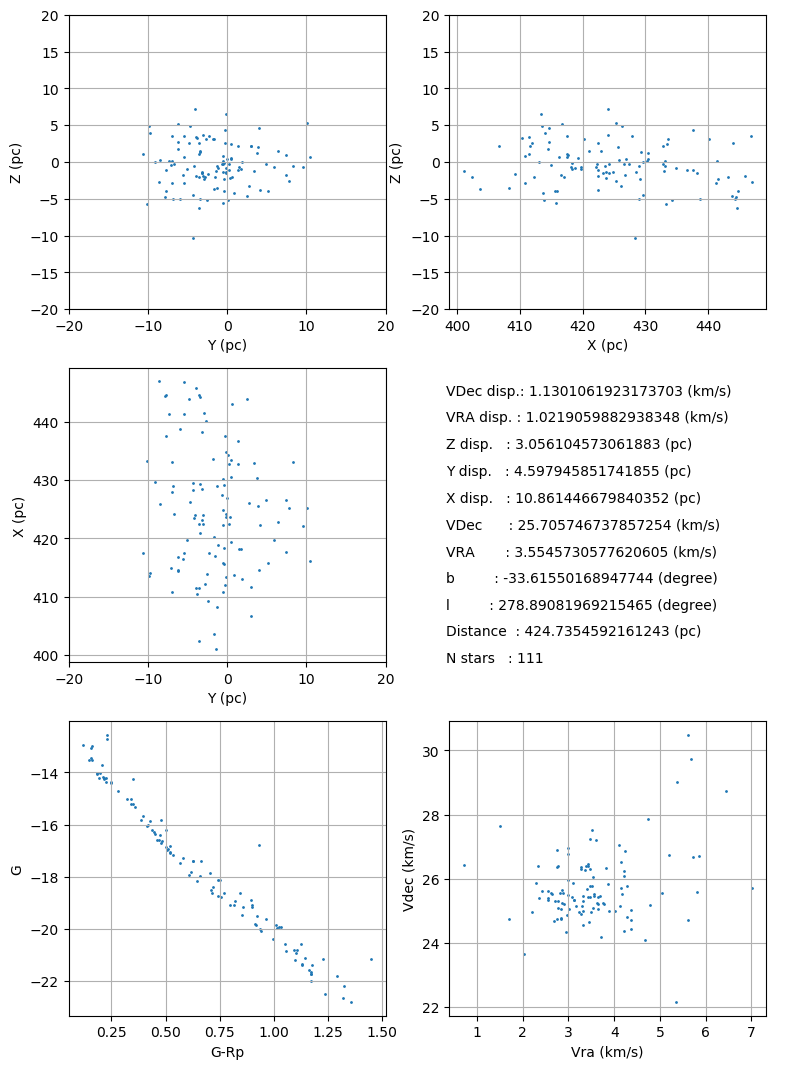

GaiaClustering.SCproperties(111, 424.7354592161243, 278.89081969215465, -33.61550168947744, 3.5545730577620605, 25.705746737857254, 10.861446679840352, 4.597945851741855, 3.056104573061883, 1.0219059882938348, 1.1301061923173703)


In [4]:
macro main(votname)
    Random.seed!(1237)
    println("## Main ...")
    
    ## Get the cluster data..
    df ,  dfcart, dfnorm = getdata(votname)
    
    eps = 2.5
    min_nei = 5
    min_cl = 15
    println("ϵ : $eps")

    println("## dbscan..")
    labels = clusters(dfnorm.data , eps , 20, min_nei, min_cl)
    labelmax , nmax = find_cluster_label(labels)
    println("## done.")
    
    println("### $(length(labels)) clusters found.")
    println("### Label solution: $labelmax")
    println("### N stars: $nmax")
    scproperties = _get_properties_SC(labels[labelmax] , df, dfcart)
    println(scproperties)
    
    _plot_cluster(plotdir, votname, labels[labelmax], scproperties,  dfcart)
    
    
end

@main("test.vot")